<a href="https://colab.research.google.com/github/J-J-Allison/Spark-ML/blob/main/PySpark_ECommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examen Final : Analyse et Modélisation Big Data avec PySpark
## Analyse E-Commerce — Segmentation Client & Modèle Prédictif

**Objectifs :**
1. Segmenter la clientèle via un clustering non supervisé (BisectingKMeans & GaussianMixture)
2. Prédire si un client est un « gros dépensier » via un modèle supervisé (classification binaire)

**Dataset :** Online Retail (UCI Machine Learning Repository)

In [ ]:
!pip install -q gdown

FILE_ID = "1e3JrdZHo4fpmcnf4h8-m6XA4JKt-u2hb"

!gdown --id $FILE_ID -O Online_Retail_CSV.csv

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e3JrdZHo4fpmcnf4h8-m6XA4JKt-u2hb
To: /content/Online_Retail_CSV.csv
100% 46.1M/46.1M [00:00<00:00, 124MB/s]


---
## 1. Initialisation & Chargement des Données

On commence par installer PySpark et configurer la SparkSession.
On utilise le dataset « Online Retail » disponible publiquement.

In [ ]:
# 1.1 Installation des dépendances

# Décommenter si vous êtes sur Google Colab :
# !pip install pyspark

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1.2 Imports

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import BisectingKMeans, GaussianMixture
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import (
    ClusteringEvaluator,
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print('Imports OK')

Imports OK


In [ ]:
# 1.3 Création de la SparkSession

spark = SparkSession.builder \
    .appName('EcommerceAnalysis') \
    .config('spark.sql.legacy.timeParserPolicy', 'LEGACY') \
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')
print(f'Spark version: {spark.version}')

Spark version: 4.0.2


In [ ]:
# 1.4 Conversion Spark Dataframe

df_raw = spark.read.csv(
    "Online_Retail_CSV.csv",
    header=True,
    sep=";",
    inferSchema=True
)

print(f'Nombre de lignes : {df_raw.count()}')
print(f'Nombre de colonnes : {len(df_raw.columns)}')
print(f'\nSchéma :')
df_raw.printSchema()

Nombre de lignes : 541909
Nombre de colonnes : 8

Schéma :
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
# 1.5 Aperçu des données

df_raw.show(10, truncate=False)

+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate     |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+----------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |01/12/2010 08:26|2,55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |01/12/2010 08:26|3,39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |01/12/2010 08:26|2,75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |01/12/2010 08:26|3,39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |01/12/2010 08:26|3,39     |17850     |United Kingdom|
|536365   |22752    |SET 7 BABUSHKA NEST

---
## 2. Exploration & Prétraitement

Avant toute modélisation, il faut comprendre les données, repérer les anomalies,
et nettoyer le dataset.

In [ ]:
# 2.1 Statistiques descriptives de base

df_raw.describe().show()

print(f"Nombre de clients distincts : {df_raw.select('CustomerID').distinct().count()}")
print(f"Nombre de produits distincts : {df_raw.select('StockCode').distinct().count()}")
print(f"Nombre de pays : {df_raw.select('Country').distinct().count()}")
print(f"Nombre de factures : {df_raw.select('InvoiceNo').distinct().count()}")

+-------+------------------+------------------+--------------------+-----------------+----------------+------------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|     InvoiceDate|         UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+----------------+------------------+------------------+-----------+
|  count|            541909|            541909|              540455|           541909|          541909|            541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0| 9.55224954743324|            NULL|29.921163668665333|15287.690570239585|       NULL|
| stddev|13428.417280805868|16799.737628427727|                NULL|218.0811578502349|            NULL|  595.745552598911|1713.6003033215957|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|        

In [ ]:
# 2.2 Vérification des valeurs manquantes

# On calcule le nombre et le pourcentage de nulls par colonne

total_rows = df_raw.count()

null_counts = df_raw.select(
    [F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_raw.columns]
)

print('Valeurs manquantes par colonne :')
null_pd = null_counts.toPandas().T
null_pd.columns = ['count']
null_pd['percentage'] = (null_pd['count'] / total_rows * 100).round(2)
print(null_pd)

Valeurs manquantes par colonne :
              count  percentage
InvoiceNo         0        0.00
StockCode         0        0.00
Description    1454        0.27
Quantity          0        0.00
InvoiceDate       0        0.00
UnitPrice         0        0.00
CustomerID   135080       24.93
Country           0        0.00


### Décisions de nettoyage

**Observations clés :**
- `CustomerID` a ~25% de valeurs manquantes → on les supprime car on ne peut pas
  construire de profil RFM sans identifiant client.
- `Description` a quelques nulls → peu d'impact pour notre analyse RFM.
- `Quantity` négatif = retours/annulations → on les filtre.
- `UnitPrice` = 0 ou négatif → on les filtre.
- Les factures commençant par 'C' sont des annulations → on les exclut.
- Certain `stock codes` ne représentent pas des commandes réelles (postage, fees, etc.)

In [ ]:
# 2.3 Nettoyage des données

# Corriger le format décimal européen (virgule → point)
df_raw = df_raw.withColumn(
    'UnitPrice',
    F.regexp_replace(F.col('UnitPrice'), ',', '.').cast(DoubleType())
)
df_raw = df_raw.withColumn(
    'Quantity',
    F.regexp_replace(F.col('Quantity'), ',', '.').cast(IntegerType())
)


df_raw.describe().show()

print(f"Nombre de clients distincts : {df_raw.select('CustomerID').distinct().count()}")
print(f"Nombre de produits distincts : {df_raw.select('StockCode').distinct().count()}")
print(f"Nombre de pays : {df_raw.select('Country').distinct().count()}")
print(f"Nombre de factures : {df_raw.select('InvoiceNo').distinct().count()}")


# Supprimer les doublons exacts
count_before_dedup = df_raw.count()
df_raw = df_raw.dropDuplicates()
count_after_dedup = df_raw.count()
print(f'Doublons supprimés : {count_before_dedup - count_after_dedup}')


# Filtrage suppression des transactions annulées, des valeurs manquantes et des montants ou quantités non valides.
df_clean = df_raw.filter(
    (F.col('CustomerID').isNotNull()) &
    (~F.isnan('CustomerID')) &
    (F.col('Quantity') > 0) &
    (F.col('UnitPrice') > 0) &
    (~F.col('InvoiceNo').startswith('C'))
)

# On supprime les stock codes qui ne représentent pas des commandes réelles (postage, fees, etc.)
df_clean = df_clean.filter(F.col('StockCode').rlike('^[0-9]{5}'))

# Vérifier les doublons
nb_before = df_clean.count()
df_clean = df_clean.dropDuplicates()
nb_after = df_clean.count()
print(f'Doublons supprimés : {nb_before - nb_after}')

# Conversions de types
df_clean = df_clean.withColumn('CustomerID', F.col('CustomerID').cast(IntegerType()))
df_clean = df_clean.withColumn('InvoiceDate', F.to_timestamp('InvoiceDate', 'dd/MM/yyyy HH:mm'))

# Créer la colonne TotalPrice
df_clean = df_clean.withColumn('TotalPrice', F.round(F.col('Quantity') * F.col('UnitPrice'), 2))

# Cache pour éviter les recalculs
df_clean.cache()

# Stocker les counts pour ne pas recalculer df_raw.count() 3 fois
count_before = df_raw.count()
count_after = df_clean.count()

print(f'Lignes avant nettoyage : {count_before}')
print(f'Lignes après nettoyage : {count_after}')
print(f'Lignes supprimées : {count_before - count_after}')
print(f'\nClients restants : {df_clean.select("CustomerID").distinct().count()}')

+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|     InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|           541909|          541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0| 9.55224954743324|            NULL|4.611113626082965|15287.690570239585|       NULL|
| stddev|13428.417280805868|16799.737628427727|                NULL|218.0811578502349|            NULL|96.75985306117937|1713.6003033215957|       NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|           -80

In [ ]:
df_raw.filter(
    F.col('CustomerID').isNotNull() &
    (F.trim(F.col('CustomerID').cast('string')) == '')
).count()

0

In [ ]:
df_clean.cache()

DataFrame[InvoiceNo: string, StockCode: string, Description: string, Quantity: int, InvoiceDate: timestamp, UnitPrice: double, CustomerID: int, Country: string, TotalPrice: double]

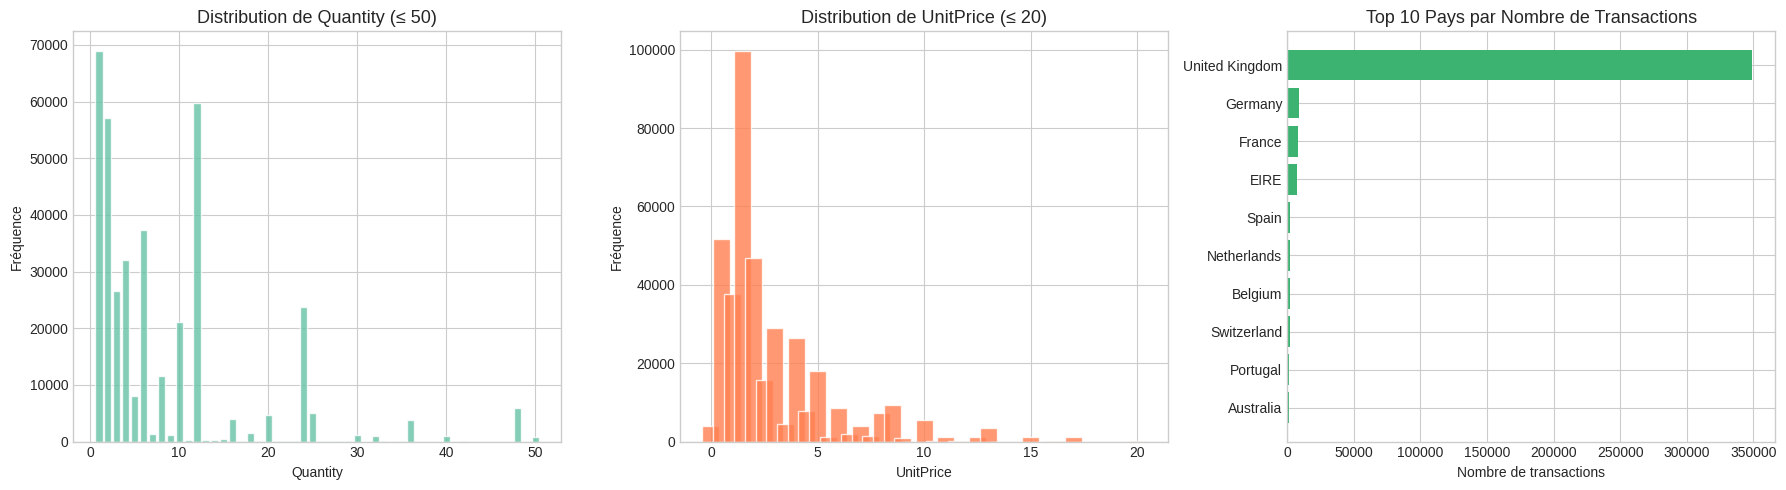

In [ ]:
# 2.4 Exploration visuelle


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribution de Quantity (on limite pour lisibilité)
qty_hist = df_clean.filter(
    (F.col('Quantity') >= -50) & (F.col('Quantity') <= 50)
).groupBy('Quantity').count().orderBy('Quantity').toPandas()
axes[0].bar(qty_hist['Quantity'], qty_hist['count'], edgecolor='white', alpha=0.8)
axes[0].set_title('Distribution de Quantity (≤ 50)', fontsize=13)
axes[0].set_xlabel('Quantity')
axes[0].set_ylabel('Fréquence')

# Distribution de UnitPrice (on limite pour lisibilité)
price_hist = df_clean.filter(F.col('UnitPrice') <= 20) \
    .withColumn('PriceBin', F.round(F.col('UnitPrice') * 2) / 2) \
    .groupBy('PriceBin').count().orderBy('PriceBin').toPandas()
axes[1].bar(price_hist['PriceBin'], price_hist['count'], edgecolor='white', alpha=0.8, color='coral')
axes[1].set_title('Distribution de UnitPrice (≤ 20)', fontsize=13)
axes[1].set_xlabel('UnitPrice')
axes[1].set_ylabel('Fréquence')

# Top 10 pays par nombre de transactions
country_pd = df_clean.groupBy('Country').count().orderBy(F.desc('count')).limit(10).toPandas()
axes[2].barh(country_pd['Country'], country_pd['count'], color='mediumseagreen')
axes[2].set_title('Top 10 Pays par Nombre de Transactions', fontsize=13)
axes[2].set_xlabel('Nombre de transactions')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

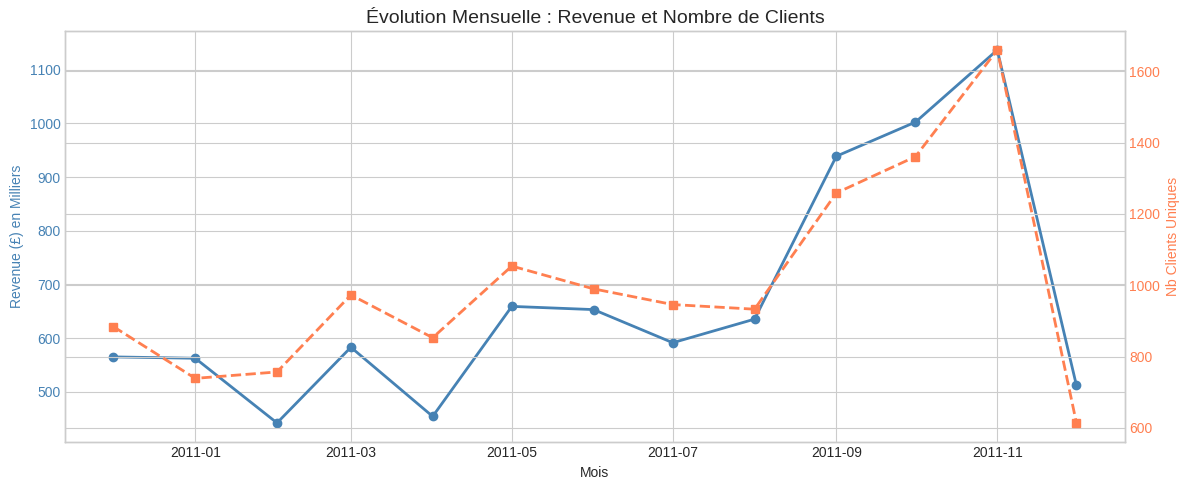

In [ ]:
# 2.5 Évolution temporelle des ventes

monthly = df_clean.withColumn('Month', F.date_trunc('month', 'InvoiceDate')) \
    .groupBy('Month') \
    .agg(
        F.sum('TotalPrice').alias('Revenue'),
        F.countDistinct('InvoiceNo').alias('NbTransactions'),
        F.countDistinct('CustomerID').alias('NbClients')
    ) \
    .orderBy('Month') \
    .toPandas()

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(monthly['Month'], monthly['Revenue'] / 1000, 'o-', color='steelblue', linewidth=2, label='Revenue (£)')
ax1.set_xlabel('Mois')
ax1.set_ylabel('Revenue (£) en Milliers', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(monthly['Month'], monthly['NbClients'], 's--', color='coral', linewidth=2, label='Nb Clients')
ax2.set_ylabel('Nb Clients Uniques', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

plt.title('Évolution Mensuelle : Revenue et Nombre de Clients', fontsize=14)
fig.tight_layout()
plt.savefig('monthly_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. Segmentation Client — Clustering Non Supervisé

### 3.1 Construction des Variables RFM

Le modèle RFM (Recency, Frequency, Monetary) est un standard de la segmentation client :
- **Recency** : combien de jours depuis le dernier achat → plus c'est bas, mieux c'est
- **Frequency** : combien de commandes distinctes → plus c'est haut, mieux c'est
- **Monetary** : montant total dépensé → plus c'est haut, mieux c'est

In [ ]:
# 3.1 Calcul des variables RFM

# Date de référence = date max du dataset + 1 jour
max_date = df_clean.agg(F.max('InvoiceDate')).collect()[0][0]
print(f'Date max dans le dataset : {max_date}')

# Construire le DataFrame RFM par client
rfm = df_clean.groupBy('CustomerID').agg(
    F.datediff(F.lit(max_date), F.max('InvoiceDate')).alias('Recency'),
    F.countDistinct('InvoiceNo').alias('Frequency'),
    F.round(F.sum('TotalPrice'), 2).alias('Monetary')
)
# Filtrer les valeurs aberrantes (monetary <= 0 possible si edge cases)
rfm = rfm.filter(F.col('Monetary') > 0)
rfm.cache()

print(f'\nNombre de clients dans le RFM : {rfm.count()}')
rfm.describe().show()
rfm.show(10)

Date max dans le dataset : 2011-12-09 12:50:00

Nombre de clients dans le RFM : 4334
+-------+------------------+------------------+------------------+------------------+
|summary|        CustomerID|           Recency|         Frequency|          Monetary|
+-------+------------------+------------------+------------------+------------------+
|  count|              4334|              4334|              4334|              4334|
|   mean|   15299.251730503| 92.22658052607291|4.2459621596677435|2015.9731518227975|
| stddev|1721.9941090491045|100.17532691386347| 7.634988822054662| 8903.673824788817|
|    min|             12346|                 0|                 1|              3.75|
|    max|             18287|               373|               206|         279138.02|
+-------+------------------+------------------+------------------+------------------+

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15727|     16|

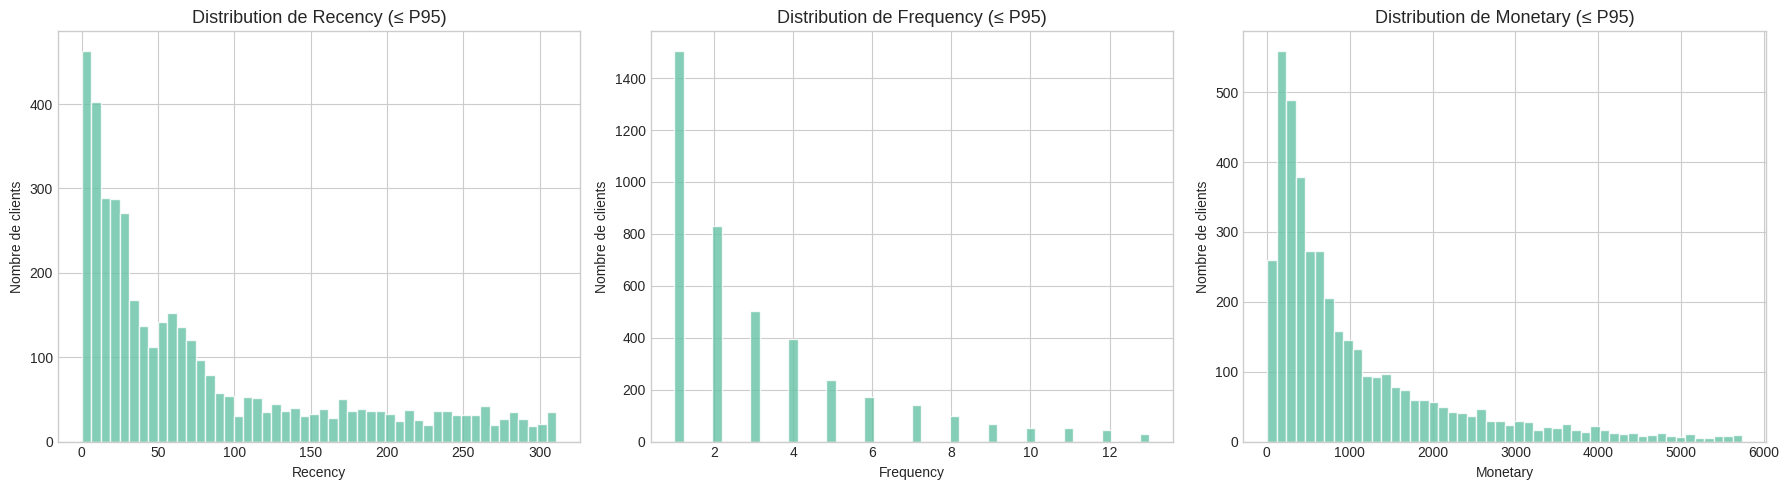

Les distributions sont fortement asymétriques (right-skewed), ce qui est typique.
La standardisation sera essentielle avant le clustering.


In [ ]:
# 3.2 Visualisation des distributions RFM

rfm_pd = rfm.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    # On utilise des percentiles pour exclure les outliers extrêmes de la visualisation
    upper = rfm_pd[col].quantile(0.95)
    data = rfm_pd[rfm_pd[col] <= upper][col]
    axes[i].hist(data, bins=50, edgecolor='white', alpha=0.8)
    axes[i].set_title(f'Distribution de {col} (≤ P95)', fontsize=13)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Nombre de clients')

plt.tight_layout()
plt.savefig('rfm_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print('Les distributions sont fortement asymétriques (right-skewed), ce qui est typique.')
print('La standardisation sera essentielle avant le clustering.')

### 3.3 Préparation des Features pour le Clustering

On assemble les 3 variables RFM dans un vecteur, puis on standardise
(centrage-réduction) pour que chaque variable ait le même poids dans le clustering.

In [ ]:
# 3.3 VectorAssembler + StandardScaler

# Assembler les features en un seul vecteur
assembler = VectorAssembler(
    inputCols=['Recency', 'Frequency', 'Monetary'],
    outputCol='features_raw'
)

# Standardiser (z-score)
scaler = StandardScaler(
    inputCol='features_raw',
    outputCol='features',
    withStd=True,
    withMean=False  #pour eviter les NAN
)

# Appliquer
rfm_assembled = assembler.transform(rfm)
scaler_model = scaler.fit(rfm_assembled)
rfm_scaled = scaler_model.transform(rfm_assembled)

rfm_scaled.cache()
rfm_scaled.count()
rfm_scaled.select('CustomerID', 'Recency', 'Frequency', 'Monetary', 'features').show(5, truncate=False)

+----------+-------+---------+--------+------------------------------------------------------------+
|CustomerID|Recency|Frequency|Monetary|features                                                    |
+----------+-------+---------+--------+------------------------------------------------------------+
|15727     |16     |7        |5159.06 |[0.15971996790944062,0.9168317286568364,0.5794304802177949] |
|13285     |23     |4        |2709.12 |[0.2295974538698209,0.5239038449467637,0.3042699062557195]  |
|17389     |0      |34       |31833.68|[0.0,4.453182682047491,3.5753421145518]                     |
|16503     |106    |4        |1431.93 |[1.058144787400044,0.5239038449467637,0.1608246245514235]   |
|14450     |180    |3        |483.25  |[1.796849638981207,0.39292788371007276,0.054275348525748744]|
+----------+-------+---------+--------+------------------------------------------------------------+
only showing top 5 rows


### 3.4 Choix du Nombre Optimal de Clusters

On teste plusieurs valeurs de k (2 à 8) et on évalue avec :
- **Silhouette Score** : mesure la cohésion intra-cluster et la séparation inter-cluster
  (plus c'est proche de 1, mieux c'est)
- **WSSSE** (Within-cluster Sum of Squared Errors) : méthode du coude

In [ ]:
# 3.4 Recherche du k optimal — BisectingKMeans

evaluator = ClusteringEvaluator(
    predictionCol='prediction',
    featuresCol='features',
    metricName='silhouette'
)

k_range = range(2, 9)
silhouette_scores = []
wssse_scores = []

for k in k_range:
    bkm = BisectingKMeans(k=k, featuresCol='features', predictionCol='prediction', seed=42)
    model = bkm.fit(rfm_scaled)
    predictions = model.transform(rfm_scaled)

    sil = evaluator.evaluate(predictions)
    wssse = model.computeCost(rfm_scaled)

    silhouette_scores.append(sil)
    wssse_scores.append(wssse)
    print(f'k={k} | Silhouette={sil:.4f} | WSSSE={wssse:.2f}')

print('\n✅ Recherche terminée.')

k=2 | Silhouette=0.4653 | WSSSE=9344.00
k=3 | Silhouette=0.7437 | WSSSE=5435.09
k=4 | Silhouette=0.5671 | WSSSE=5060.28
k=5 | Silhouette=0.6846 | WSSSE=3976.25
k=6 | Silhouette=0.5515 | WSSSE=3928.86
k=7 | Silhouette=0.5532 | WSSSE=3872.13
k=8 | Silhouette=0.5552 | WSSSE=2697.91

✅ Recherche terminée.


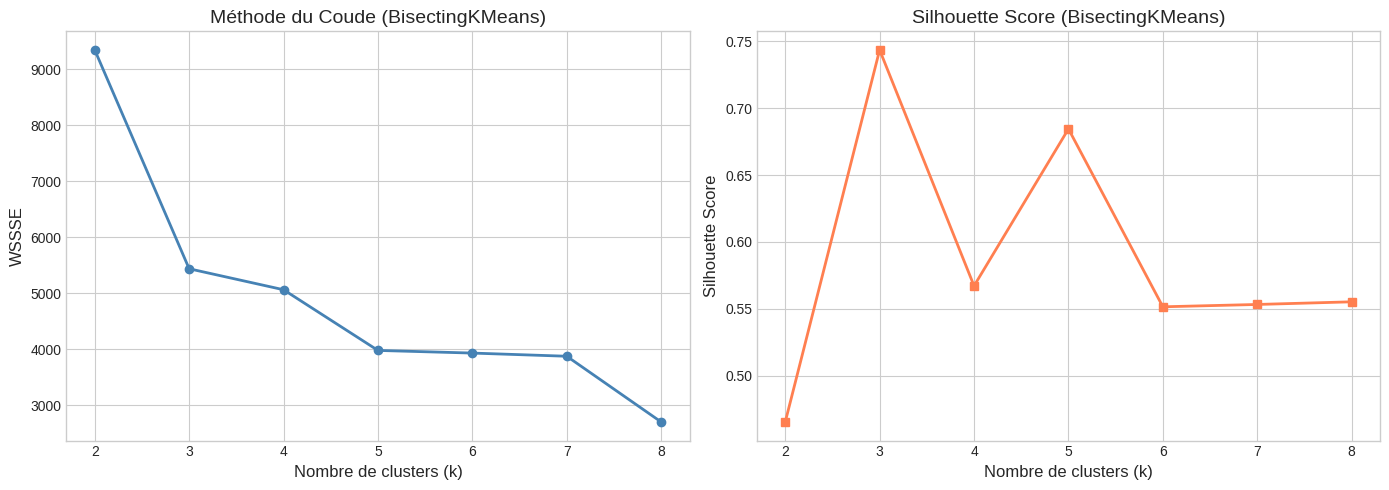


🏆 Meilleur k selon Silhouette : k=3 (score=0.7437)


In [ ]:
# 3.5 Visualisation : Coude + Silhouette

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Méthode du coude (WSSSE)
ax1.plot(list(k_range), wssse_scores, 'o-', linewidth=2, color='steelblue')
ax1.set_xlabel('Nombre de clusters (k)', fontsize=12)
ax1.set_ylabel('WSSSE', fontsize=12)
ax1.set_title('Méthode du Coude (BisectingKMeans)', fontsize=14)
ax1.set_xticks(list(k_range))

# Silhouette Score
ax2.plot(list(k_range), silhouette_scores, 's-', linewidth=2, color='coral')
ax2.set_xlabel('Nombre de clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score (BisectingKMeans)', fontsize=14)
ax2.set_xticks(list(k_range))

plt.tight_layout()
plt.savefig('elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

# Identifier le meilleur k
best_k = list(k_range)[np.argmax(silhouette_scores)]
print(f'\n🏆 Meilleur k selon Silhouette : k={best_k} (score={max(silhouette_scores):.4f})')

### 3.6 Modèle Final — BisectingKMeans

On entraîne le modèle avec le k optimal identifié, puis on analyse les segments.

In [ ]:
# 3.6 Entraînement du modèle final (BisectingKMeans)

# Utiliser le meilleur k trouvé
OPTIMAL_K = best_k

bkm_final = BisectingKMeans(
    k=OPTIMAL_K,
    featuresCol='features',
    predictionCol='cluster',
    seed=42
)

bkm_model = bkm_final.fit(rfm_scaled)
rfm_clustered = bkm_model.transform(rfm_scaled)

# Score Silhouette final
eval_final = ClusteringEvaluator(predictionCol='cluster', featuresCol='features', metricName='silhouette')
sil_final = eval_final.evaluate(rfm_clustered)
print(f'Silhouette Score final (k={OPTIMAL_K}) : {sil_final:.4f}')

# Distribution des clusters
print('\nDistribution des clients par cluster :')
rfm_clustered.groupBy('cluster').count().orderBy('cluster').show()

Silhouette Score final (k=3) : 0.7437

Distribution des clients par cluster :
+-------+-----+
|cluster|count|
+-------+-----+
|      0| 3200|
|      1|   25|
|      2| 1109|
+-------+-----+



In [ ]:
# 3.7 Comparaison avec GaussianMixture (GMM)

# On compare BisectingKMeans avec GaussianMixture pour enrichir l'analyse.

gmm = GaussianMixture(
    k=OPTIMAL_K,
    featuresCol='features',
    predictionCol='gmm_cluster',
    seed=42
)

gmm_model = gmm.fit(rfm_scaled)
rfm_gmm = gmm_model.transform(rfm_scaled)

eval_gmm = ClusteringEvaluator(predictionCol='gmm_cluster', featuresCol='features', metricName='silhouette')
sil_gmm = eval_gmm.evaluate(rfm_gmm)
print(f'Silhouette Score GMM (k={OPTIMAL_K}) : {sil_gmm:.4f}')
print(f'Silhouette Score BisectingKMeans (k={OPTIMAL_K}) : {sil_final:.4f}')
print(f'\n→ On retient le modèle avec le meilleur Silhouette pour la suite.')

# Distribution GMM
print('\nDistribution GMM :')
rfm_gmm.groupBy('gmm_cluster').count().orderBy('gmm_cluster').show()

Silhouette Score GMM (k=3) : 0.1768
Silhouette Score BisectingKMeans (k=3) : 0.7437

→ On retient le modèle avec le meilleur Silhouette pour la suite.

Distribution GMM :
+-----------+-----+
|gmm_cluster|count|
+-----------+-----+
|          0| 1003|
|          1| 3180|
|          2|  151|
+-----------+-----+



### 3.8 Analyse et Interprétation des Segments

On examine la moyenne de chaque variable RFM par cluster pour comprendre
le profil de chaque segment.

In [ ]:
# 3.8 Profils des clusters (BisectingKMeans)

cluster_profiles = rfm_clustered.groupBy('cluster').agg(
    F.count('CustomerID').alias('Nb_Clients'),
    F.round(F.mean('Recency'), 1).alias('Avg_Recency'),
    F.round(F.mean('Frequency'), 1).alias('Avg_Frequency'),
    F.round(F.mean('Monetary'), 2).alias('Avg_Monetary'),
    F.round(F.median('Monetary'), 2).alias('Median_Monetary')
).orderBy('cluster')

print('Profils moyens par cluster :')
cluster_profiles.show(truncate=False)

Profils moyens par cluster :
+-------+----------+-----------+-------------+------------+---------------+
|cluster|Nb_Clients|Avg_Recency|Avg_Frequency|Avg_Monetary|Median_Monetary|
+-------+----------+-----------+-------------+------------+---------------+
|0      |3200      |40.2       |4.7          |1856.29     |912.3          |
|1      |25        |5.5        |67.8         |85859.88    |58762.08       |
|2      |1109      |244.3      |1.6          |586.65      |309.36         |
+-------+----------+-----------+-------------+------------+---------------+



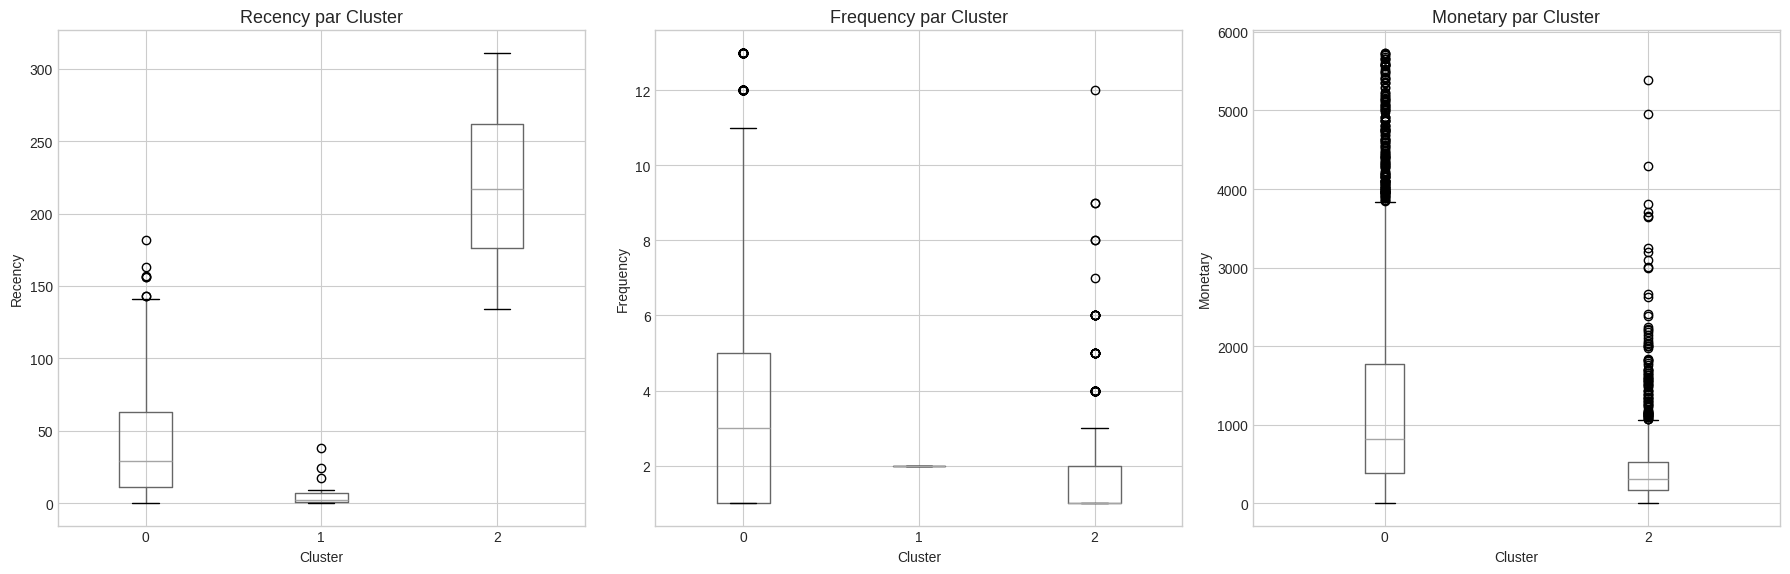

In [ ]:
# 3.9 Visualisation des segments

clust_pd = rfm_clustered.select('CustomerID', 'Recency', 'Frequency', 'Monetary', 'cluster').toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    # Box plot par cluster (on cap pour lisibilité)
    upper = clust_pd[col].quantile(0.95)
    data_capped = clust_pd[clust_pd[col] <= upper]
    data_capped.boxplot(column=col, by='cluster', ax=axes[i])
    axes[i].set_title(f'{col} par Cluster', fontsize=13)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)
    plt.suptitle('')  # Supprimer le titre automatique

plt.tight_layout()
plt.savefig('cluster_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

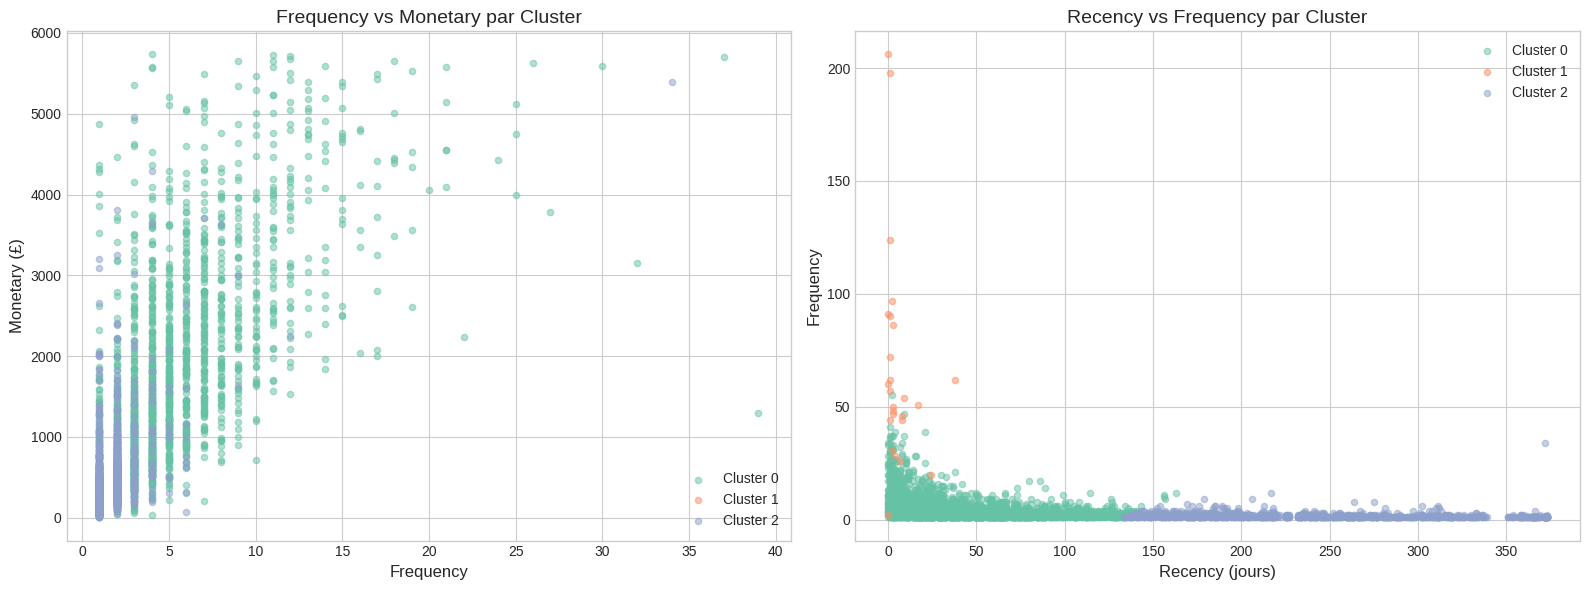

In [ ]:
# 3.10 Scatter plot 2D des segments

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Frequency vs Monetary
for c in sorted(clust_pd['cluster'].unique()):
    mask = clust_pd['cluster'] == c
    # Cap outliers for visualization
    sub = clust_pd[mask & (clust_pd['Monetary'] <= clust_pd['Monetary'].quantile(0.95))]
    axes[0].scatter(sub['Frequency'], sub['Monetary'], alpha=0.5, label=f'Cluster {c}', s=20)

axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_ylabel('Monetary (£)', fontsize=12)
axes[0].set_title('Frequency vs Monetary par Cluster', fontsize=14)
axes[0].legend()

# Recency vs Frequency
for c in sorted(clust_pd['cluster'].unique()):
    mask = clust_pd['cluster'] == c
    sub = clust_pd[mask]
    axes[1].scatter(sub['Recency'], sub['Frequency'], alpha=0.5, label=f'Cluster {c}', s=20)

axes[1].set_xlabel('Recency (jours)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Recency vs Frequency par Cluster', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.savefig('cluster_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.11 Interprétation des Segments

Sur la base des moyennes RFM par cluster, on peut nommer les segments et proposer des actions marketing adaptées.


| Cluster | Profil Type                 | Recency             | Frequency                    | Monetary              | Action Marketing                              |
| ------- | --------------------------- | ------------------- | ---------------------------- | --------------------- | --------------------------------------------- |
| 0       | Occasionnels réguliers      | Moyenne (40 j)      | Moyenne (4.7 commandes)      | Moyen (1 856 €)       | Campagnes de relance, cross-sell              |
| 1       | Gros clients / VIP          | Très faible (5.5 j) | Très élevée (67.8 commandes) | Très élevé (85 860 €) | Programme fidélité premium, offres exclusives |
| 2       | Clients inactifs / à risque | Très élevée (244 j) | Faible (1.6 commandes)       | Faible (586 €)        | Campagnes de réactivation, offres incitatives |


SYNTHÈSE ÉCONOMIQUE PAR CLUSTER :
+-------+----------+-----------+-------------+------------+-------------+---------------+---------------+--------------+
|cluster|Nb_Clients|Avg_Recency|Avg_Frequency|Avg_Monetary|Total_Revenue|Avg_Basket_Size|Revenue_Share_%|Client_Share_%|
+-------+----------+-----------+-------------+------------+-------------+---------------+---------------+--------------+
|0      |3200      |40.2       |4.7          |1856.29     |5940141.17   |385.57         |68.0           |73.8          |
|1      |25        |5.5        |67.8         |85859.88    |2146496.89   |4956.5         |24.6           |0.6           |
|2      |1109      |244.3      |1.6          |586.65      |650589.58    |399.44         |7.4            |25.6          |
+-------+----------+-----------+-------------+------------+-------------+---------------+---------------+--------------+


========== CLUSTER 0 — 3200 clients ==========


,CustomerID,Country,Recency,Frequency,Monetary
0,14096,United Kingdom,4,17,53258.43
1,14088,United Kingdom,10,13,50491.81
2,12931,United Kingdom,21,15,42055.96
3,15098,United Kingdom,182,3,39916.50
4,15838,United Kingdom,11,19,33643.08
...,...,...,...,...,...
3195,16093,United Kingdom,106,1,17.00
3196,13307,United Kingdom,120,1,15.00
3197,16878,United Kingdom,84,1,13.30
3198,14792,United Kingdom,63,1,6.20



========== CLUSTER 1 — 25 clients ==========


,CustomerID,Country,Recency,Frequency,Monetary
0,14646,Netherlands,1,72,279138.02
1,18102,United Kingdom,0,60,259657.30
2,17450,United Kingdom,8,46,194390.79
3,16446,United Kingdom,0,2,168472.50
4,14911,EIRE,1,198,136161.83
5,12415,Australia,24,20,124564.53
6,14156,EIRE,9,54,116560.08
7,17511,United Kingdom,2,31,91062.38
8,16029,United Kingdom,38,62,72708.09
9,16684,United Kingdom,4,28,66653.56



========== CLUSTER 2 — 1109 clients ==========


,CustomerID,Country,Recency,Frequency,Monetary
0,12346,United Kingdom,325,1,77183.60
1,15749,United Kingdom,235,3,44534.30
2,12590,Germany,211,1,9341.26
3,13093,United Kingdom,275,8,7832.47
4,17850,United Kingdom,372,34,5391.21
...,...,...,...,...,...
1104,17102,United Kingdom,261,1,25.50
1105,16257,United Kingdom,176,1,21.95
1106,17763,United Kingdom,263,1,15.00
1107,17956,United Kingdom,249,1,12.75


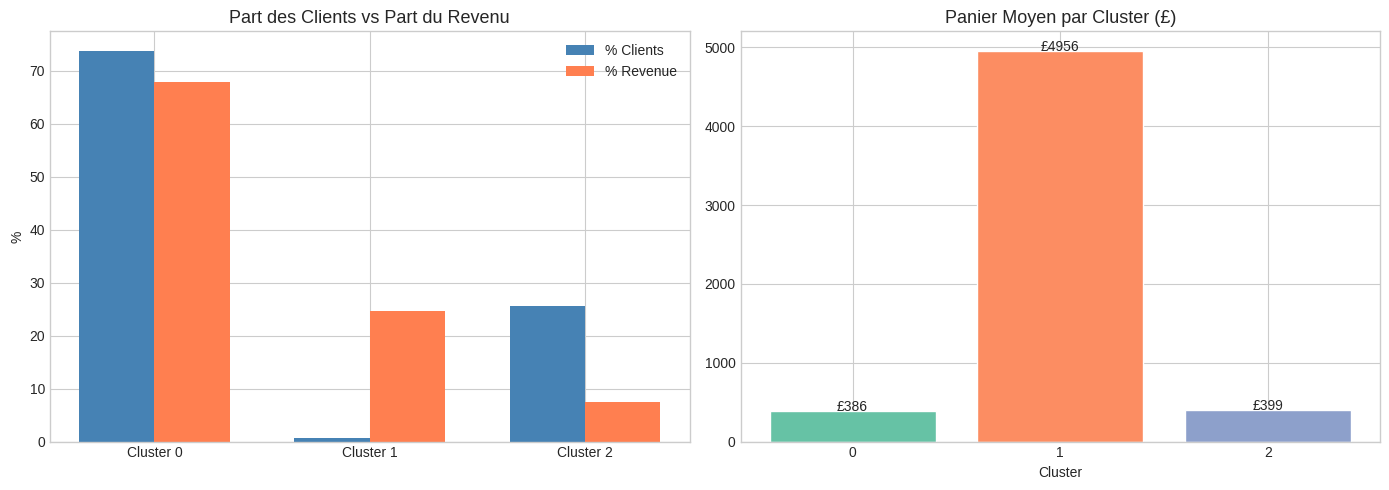

In [ ]:
# 3.12 Interprétation supplémentaire

# CLIENTS + ANALYSE ÉCONOMIQUE DES CLUSTERS


client_country = df_clean.groupBy('CustomerID').agg(
    F.first('Country').alias('Country')
)

total_revenue = rfm_clustered.agg(F.sum('Monetary')).collect()[0][0]
total_clients = rfm_clustered.count()

# 1. Tableau économique synthétique
economic_summary = rfm_clustered.withColumn(
    'Avg_Basket', F.round(F.col('Monetary') / F.col('Frequency'), 2)
).groupBy('cluster').agg(
    F.count('CustomerID').alias('Nb_Clients'),
    F.round(F.mean('Recency'), 1).alias('Avg_Recency'),
    F.round(F.mean('Frequency'), 1).alias('Avg_Frequency'),
    F.round(F.mean('Monetary'), 2).alias('Avg_Monetary'),
    F.round(F.sum('Monetary'), 2).alias('Total_Revenue'),
    F.round(F.mean('Avg_Basket'), 2).alias('Avg_Basket_Size')
).withColumn(
    'Revenue_Share_%', F.round(F.col('Total_Revenue') / total_revenue * 100, 1)
).withColumn(
    'Client_Share_%', F.round(F.col('Nb_Clients') / total_clients * 100, 1)
).orderBy('cluster')

print('SYNTHÈSE ÉCONOMIQUE PAR CLUSTER :')
economic_summary.show(truncate=False)

# 2. Tous les clients par cluster
for c in range(OPTIMAL_K):
    df = rfm_clustered.filter(F.col('cluster') == c) \
        .join(client_country, on='CustomerID', how='left') \
        .select('CustomerID', 'Country', 'Recency', 'Frequency', 'Monetary') \
        .orderBy(F.desc('Monetary')) \
        .toPandas()

    print(f'\n========== CLUSTER {c} — {len(df)} clients ==========')
    display(df)

# 3. Visualisation
eco_pd = economic_summary.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = range(len(eco_pd))
w = 0.35
axes[0].bar([i - w/2 for i in x], eco_pd['Client_Share_%'], w, label='% Clients', color='steelblue')
axes[0].bar([i + w/2 for i in x], eco_pd['Revenue_Share_%'], w, label='% Revenue', color='coral')
axes[0].set_xticks(list(x))
axes[0].set_xticklabels([f'Cluster {c}' for c in eco_pd['cluster']])
axes[0].set_ylabel('%')
axes[0].set_title('Part des Clients vs Part du Revenu', fontsize=13)
axes[0].legend()

axes[1].bar(eco_pd['cluster'].astype(str), eco_pd['Avg_Basket_Size'],
            color=sns.color_palette('Set2'), edgecolor='white')
axes[1].set_title('Panier Moyen par Cluster (£)', fontsize=13)
axes[1].set_xlabel('Cluster')
for i, v in enumerate(eco_pd['Avg_Basket_Size']):
    axes[1].text(i, v + 1, f'£{v:.0f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('economic_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Modélisation Supervisée — Classification Binaire

### Objectif
Prédire si un client est un "gros dépensier" (label = 1) ou un "petit dépensier"
(label = 0), sur la base de ses caractéristiques comportementales.

### Approche
Dans la partie non-supervisée, nous avons utilisé RFM pour **découvrir** des segments clients.
Ici, nous allons plus loin en créant des **features comportementales plus riches** pour **prédire** le niveau de dépense d'un client, en évitant du data leakage.

### Features utilisées
- `Recency` : jours depuis le dernier achat
- `Frequency` : nombre de commandes
- `AvgUnitPrice` : prix unitaire moyen des articles achetés
- `UniqueProducts` : nombre de produits distincts achetés
- `PurchaseSpan` : durée entre le premier et le dernier achat
- `OrderFrequencyRate` : intensité d'achat (commandes par jour actif)
- `CountryIndex` : pays du client (encodé)

### 4.1 Feature Engineering avancé

In [ ]:
# 4.1 Feature Engineering avancé

customer_features = df_clean.groupBy('CustomerID').agg(

    # --- Features temporelles ---
    F.datediff(F.lit(max_date), F.max('InvoiceDate')).alias('Recency'),
    F.countDistinct('InvoiceNo').alias('Frequency'),

    # --- Features comportementales (sans leakage) ---
    F.avg('UnitPrice').alias('AvgUnitPrice'),
    F.countDistinct('StockCode').alias('UniqueProducts'),
    F.datediff(F.max('InvoiceDate'), F.min('InvoiceDate')).alias('PurchaseSpan'),

    # --- Pays (pour encodage) ---
    F.first('Country').alias('Country'),

    # --- Monetary (uniquement pour créer le label, PAS comme feature) ---
    F.sum(F.col('Quantity') * F.col('UnitPrice')).alias('Monetary')
)

# Intensité d'achat (commandes par jour actif)
customer_features = customer_features.withColumn(
    'OrderFrequencyRate',
    F.when(F.col('PurchaseSpan') > 0,
           F.col('Frequency') / F.col('PurchaseSpan'))
    .otherwise(0.0)
)

print('Aperçu des features créées :')
customer_features.select(
    'CustomerID', 'Recency', 'Frequency',
    'AvgUnitPrice', 'UniqueProducts',
    'PurchaseSpan', 'OrderFrequencyRate', 'Monetary'
).show(10, truncate=False)

print('\nStatistiques descriptives :')
customer_features.select(
    'Recency', 'Frequency', 'AvgUnitPrice',
    'UniqueProducts', 'PurchaseSpan', 'OrderFrequencyRate'
).describe().show()

Aperçu des features créées :
+----------+-------+---------+------------------+--------------+------------+--------------------+------------------+
|CustomerID|Recency|Frequency|AvgUnitPrice      |UniqueProducts|PurchaseSpan|OrderFrequencyRate  |Monetary          |
+----------+-------+---------+------------------+--------------+------------+--------------------+------------------+
|13285     |23     |4        |2.1348663101604277|157           |267         |0.0149812734082397  |2709.12           |
|17389     |0      |34       |5.688826291079814 |45            |331         |0.1027190332326284  |31833.680000000015|
|16503     |106    |4        |4.173571428571427 |71            |254         |0.015748031496062992|1431.9300000000005|
|15727     |16     |7        |3.2258803986710975|213           |343         |0.02040816326530612 |5159.0599999999995|
|13623     |30     |5        |3.50076923076923  |75            |267         |0.018726591760299626|727.7399999999999 |
|14450     |180    |3      

### 4.2 Création de la variable cible (label)

On utilise la **médiane** du Monetary comme seuil pour créer une classification équilibrée.

In [ ]:
# 4.2 Création de la variable cible (label)

monetary_median = customer_features.approxQuantile('Monetary', [0.5], 0.01)[0]
print(f'Médiane de Monetary : {monetary_median:.2f} £')

SEUIL = monetary_median
print(f'Seuil retenu : {SEUIL:.2f} £')

customer_labeled = customer_features.withColumn(
    'label',
    F.when(F.col('Monetary') > SEUIL, 1.0).otherwise(0.0)
)

print('\nDistribution des classes :')
customer_labeled.groupBy('label').count().show()

Médiane de Monetary : 657.16 £
Seuil retenu : 657.16 £

Distribution des classes :
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 2155|
|  1.0| 2179|
+-----+-----+



### 4.3 Encodage et assemblage des features

On exclut **Monetary** (base du label → data leakage). On conserve Recency et Frequency aux côtés des nouvelles features comportementales pour maximiser le pouvoir prédictif du modèle.

In [ ]:
# 4.3 Encodage et assemblage des features

country_indexer = StringIndexer(
    inputCol='Country',
    outputCol='CountryIndex',
    handleInvalid='keep'
)

customer_labeled = country_indexer.fit(customer_labeled).transform(customer_labeled)

# Feature
feature_cols = [
    'Recency',             # Jours depuis le dernier achat
    'Frequency',           # Nombre de commandes
    'AvgUnitPrice',        # Prix unitaire moyen
    'UniqueProducts',      # Diversité des produits achetés
    'PurchaseSpan',        # Durée de vie client
    'OrderFrequencyRate',  # Intensité d'achat
    'CountryIndex'         # Pays (encodé)
]

assembler_sup = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features_sup_raw'
)

scaler_sup = StandardScaler(
    inputCol='features_sup_raw',
    outputCol='features_sup',
    withStd=True,
    withMean=True
)

prep_pipeline = Pipeline(stages=[assembler_sup, scaler_sup])
data_prepared = prep_pipeline.fit(customer_labeled).transform(customer_labeled)

# Split 70/30
train_df, test_df = data_prepared.randomSplit([0.7, 0.3], seed=42)

print(f'Taille du jeu d\'entraînement : {train_df.count()}')
print(f'Taille du jeu de test : {test_df.count()}')
print(f'\nDistribution label (train) :')
train_df.groupBy('label').count().show()
print(f'Distribution label (test) :')
test_df.groupBy('label').count().show()


Taille du jeu d'entraînement : 3100
Taille du jeu de test : 1234

Distribution label (train) :
+-----+-----+
|label|count|
+-----+-----+
|  0.0| 1514|
|  1.0| 1586|
+-----+-----+

Distribution label (test) :
+-----+-----+
|label|count|
+-----+-----+
|  0.0|  641|
|  1.0|  593|
+-----+-----+



### 4.4 Random Forest Classifier

Modèle d'ensemble, plus flexible que la régression logistique, capable de capturer les non-linéarités.

In [ ]:
# 4.4 Random Forest Classifier

rf = RandomForestClassifier(
    featuresCol='features_sup',
    labelCol='label',
    numTrees=100,
    maxDepth=5,
    seed=42
)

rf_model = rf.fit(train_df)

# Feature Importances
print('Feature Importances (Random Forest) :')
for name, imp in zip(feature_cols, rf_model.featureImportances):
    print(f'  {name:25s} : {imp:.4f}')

# Prédictions sur le test
rf_pred = rf_model.transform(test_df)

Feature Importances (Random Forest) :
  Recency                   : 0.0241
  Frequency                 : 0.4598
  AvgUnitPrice              : 0.0177
  UniqueProducts            : 0.2325
  PurchaseSpan              : 0.0686
  OrderFrequencyRate        : 0.1822
  CountryIndex              : 0.0151


### 4.5 Évaluation du modèle

In [ ]:
# 4.5 Évaluation du modèle

def evaluate_model(predictions, model_name):
    """Évalue un modèle de classification binaire et affiche les métriques."""

    acc_eval = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='accuracy'
    )
    accuracy = acc_eval.evaluate(predictions)

    prec_eval = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='weightedPrecision'
    )
    precision = prec_eval.evaluate(predictions)

    rec_eval = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='weightedRecall'
    )
    recall = rec_eval.evaluate(predictions)

    f1_eval = MulticlassClassificationEvaluator(
        labelCol='label', predictionCol='prediction', metricName='f1'
    )
    f1 = f1_eval.evaluate(predictions)

    print(f'\n===== {model_name} =====')
    print(f'  Accuracy  : {accuracy:.4f}')
    print(f'  Precision : {precision:.4f}')
    print(f'  Recall    : {recall:.4f}')
    print(f'  F1-Score  : {f1:.4f}')

    return {'model': model_name, 'Accuracy': accuracy,
            'Precision': precision, 'Recall': recall, 'F1': f1}

rf_metrics = evaluate_model(rf_pred, 'Random Forest')


===== Random Forest =====
  Accuracy  : 0.8776
  Precision : 0.8777
  Recall    : 0.8776
  F1-Score  : 0.8776


### 4.6 Démonstration du modèle sur des exemples

Affichons des prédictions individuelles pour voir le modèle en action.

In [ ]:
# 4.6 Démonstration du modèle sur des exemples

print('=== Exemples de prédictions du Random Forest ===\n')

demo_df = rf_pred.select(
    'CustomerID', 'Recency', 'Frequency', 'AvgUnitPrice',
    'UniqueProducts', 'PurchaseSpan', 'Monetary',
    'label', 'prediction', 'probability'
).limit(10)

demo_df.show(truncate=False)

correct = rf_pred.filter(F.col('label') == F.col('prediction')).count()
total = rf_pred.count()
incorrect = total - correct

print(f'\nRésultats sur le jeu de test :')
print(f'  Prédictions correctes   : {correct} / {total}')
print(f'  Prédictions incorrectes : {incorrect} / {total}')
print(f'  Taux de réussite        : {correct / total:.1%}')

print('\n=== Exemples d\'erreurs du modèle ===')
rf_pred.filter(F.col('label') != F.col('prediction')) \
    .select('CustomerID', 'Recency', 'Frequency', 'AvgUnitPrice',
            'UniqueProducts', 'Monetary', 'label', 'prediction', 'probability') \
    .limit(5) \
    .show(truncate=False)

=== Exemples de prédictions du Random Forest ===

+----------+-------+---------+------------------+--------------+------------+------------------+-----+----------+-----------------------------------------+
|CustomerID|Recency|Frequency|AvgUnitPrice      |UniqueProducts|PurchaseSpan|Monetary          |label|prediction|probability                              |
+----------+-------+---------+------------------+--------------+------------+------------------+-----+----------+-----------------------------------------+
|12348     |75     |4        |0.692962962962963 |21            |283         |1437.2400000000002|1.0  |1.0       |[0.3435807163863882,0.6564192836136119]  |
|12353     |204    |1        |6.074999999999999 |4             |0           |89.0              |0.0  |0.0       |[0.82997790217627,0.17002209782372993]   |
|12355     |214    |1        |4.203846153846154 |13            |0           |459.40000000000003|0.0  |0.0       |[0.8213129693815786,0.17868703061842142] |
|12356     |22

### 4.7 Matrice de confusion

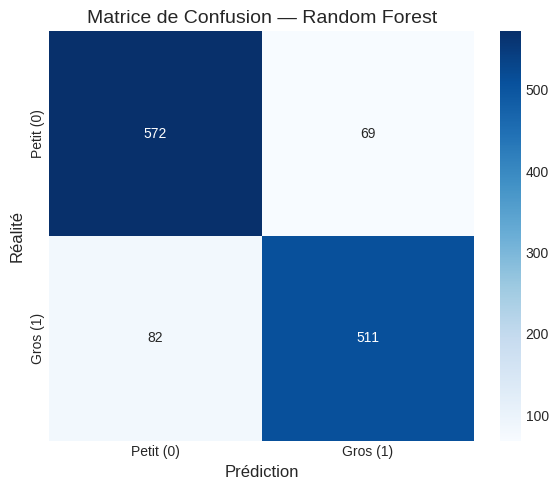

In [ ]:
# 4.7 Matrice de confusion

cm = rf_pred.select('label', 'prediction') \
    .groupBy('label', 'prediction').count() \
    .toPandas()

cm_pivot = cm.pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_pivot, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Petit (0)', 'Gros (1)'],
            yticklabels=['Petit (0)', 'Gros (1)'])
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.title('Matrice de Confusion — Random Forest', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix_rf_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.8 Feature Importance (visualisation)

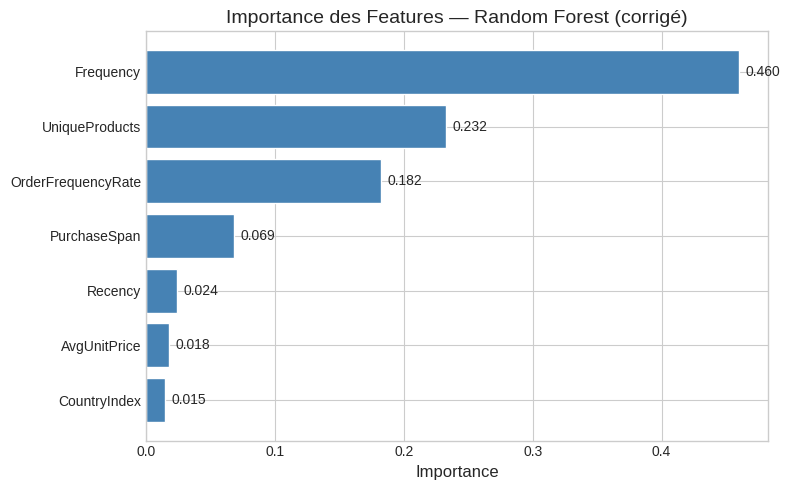

In [ ]:
# 4.8 Feature Importance (visualisation)

fi_pd = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.featureImportances.toArray()
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(fi_pd['Feature'], fi_pd['Importance'], color='steelblue', edgecolor='white')
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Importance des Features — Random Forest (corrigé)', fontsize=14)
for i, (val, name) in enumerate(zip(fi_pd['Importance'], fi_pd['Feature'])):
    ax.text(val + 0.005, i, f'{val:.3f}', va='center')
plt.tight_layout()
plt.savefig('feature_importance_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Visualisations Récapitulatives & Recommandations

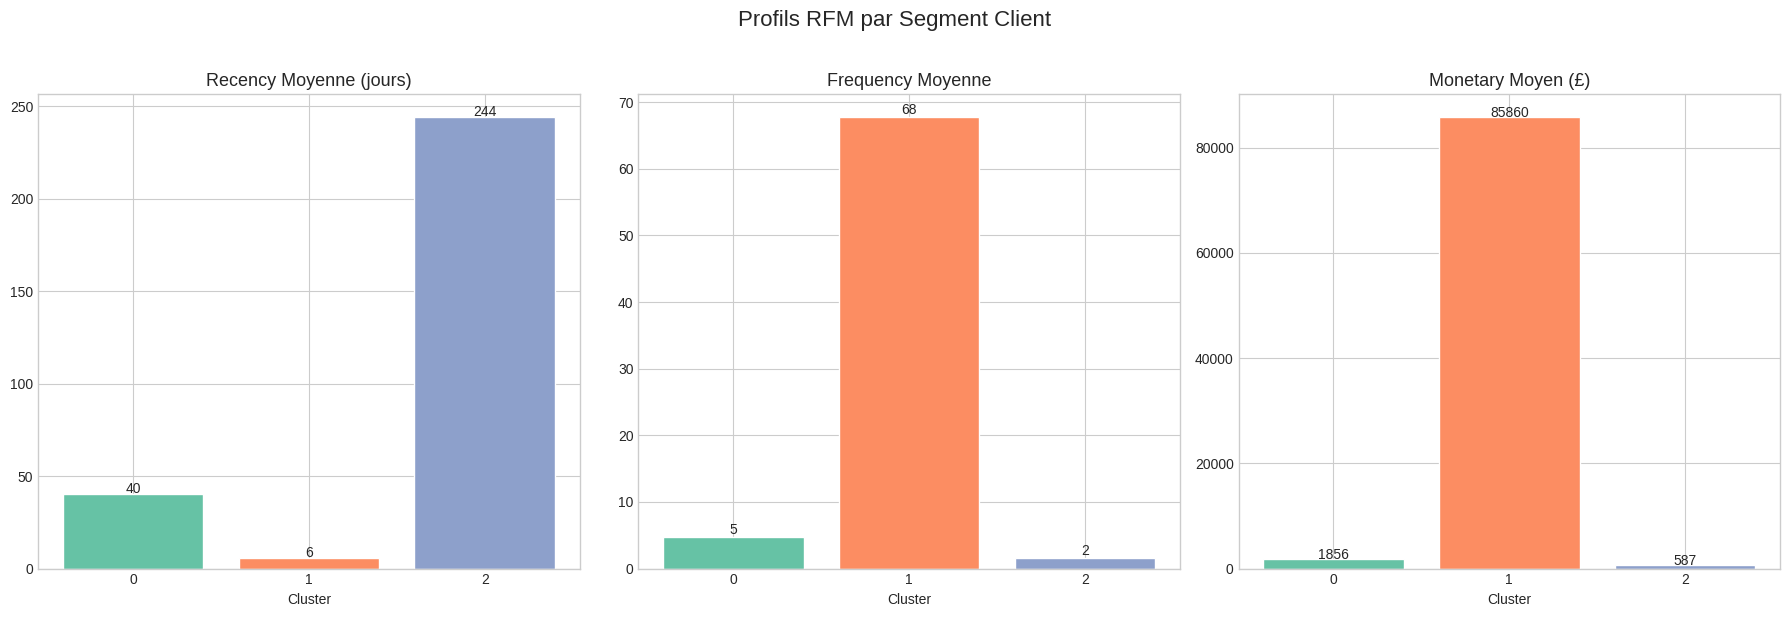

In [ ]:
# 5.1 Synthèse des segments avec actions

# Récapitulatif final des clusters
profiles_pd = cluster_profiles.toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = sns.color_palette('Set2', n_colors=len(profiles_pd))

for i, (col, title) in enumerate([
    ('Avg_Recency', 'Recency Moyenne (jours)'),
    ('Avg_Frequency', 'Frequency Moyenne'),
    ('Avg_Monetary', 'Monetary Moyen (£)')
]):
    bars = axes[i].bar(
        profiles_pd['cluster'].astype(str),
        profiles_pd[col],
        color=colors,
        edgecolor='white'
    )
    axes[i].set_title(title, fontsize=13)
    axes[i].set_xlabel('Cluster')

    for bar, val in zip(bars, profiles_pd[col]):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                     f'{val:.0f}', ha='center', fontsize=10)

plt.suptitle('Profils RFM par Segment Client', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('segment_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

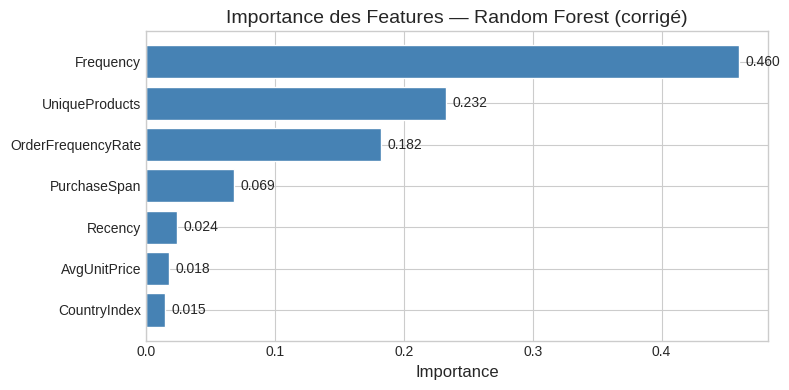

In [ ]:
# 5.2 Feature Importance (Random Forest)

fi_pd = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.featureImportances.toArray()
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(fi_pd['Feature'], fi_pd['Importance'], color='steelblue', edgecolor='white')
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Importance des Features — Random Forest (corrigé)', fontsize=14)
for i, (val, name) in enumerate(zip(fi_pd['Importance'], fi_pd['Feature'])):
    ax.text(val + 0.005, i, f'{val:.3f}', va='center')
plt.tight_layout()
plt.savefig('feature_importance_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Recommandations pour l'Entreprise

**Sur la base de la segmentation :**

Trois segments distincts ont été identifiés (Silhouette = 0.7437) :

**Cluster 1 — VIP (25 clients)** : Frequency de 67.8, recency de 5.5 jours, monetary moyen de 85 860 £. Priorité à la **rétention** : programme fidélité premium, accès anticipé aux collections, account manager dédié. Toute perte ici a un impact financier majeur.

**Cluster 0 — Réguliers (3 200 clients)** : Recency de 40 jours, monetary moyen de 1 856 £. Objectif : **augmenter la frequency** via cross-sell, recommandations personnalisées, et système de paliers pour encourager la migration vers le profil VIP.

**Cluster 2 — Inactifs (1 109 clients)** : Recency de 244 jours, 1.6 commandes, 586 £. Campagne de **réactivation en deux vagues** (offre incitative puis dernière relance), avant désactivation des communications.

**Sur la base du modèle prédictif :**

Le **Random Forest** révèle que c'est la régularité et la diversité d'achat, plus que le prix unitaire, qui distinguent les gros dépensiers.

Signaux d'alerte : Les clients classifiés « gros dépensier » dont la Frequency commence à baisser doivent déclencher une intervention de rétention avant qu'ils ne migrent vers le Cluster 2 (Inactifs).

---
## 6. Conclusion

**Segmentation (Non Supervisé)** — Le BisectingKMeans (Silhouette = 0.7437) surpasse le GMM (0.1768) et identifie 3 segments à partir des variables RFM : VIP (25 clients), Réguliers (3 200), Inactifs (1 109). Ces segments permettent de cibler des actions marketing différenciées.

**Modèle Prédictif (Supervisé)** — Le Random Forest (100 arbres, profondeur 5) atteint 87% d'accuracy et un F1 de 0.8776 sur 1 234 clients test, en utilisant 7 features comportementales. Les plus importants  : Frequency (0.46), Unique Products (0.232), OrderFrequencyRate (0.182).

### Limitations

Le dataset couvre ~1 an d'un seul commerce (principalement UK), sans données démographiques ni canal d'acquisition. Le clustering reste sensible aux outliers (25 VIP dominent la distribution Monetary).

### Pistes d'Amélioration

Clustering: Appliquer une **transformation log** sur les variables RFM avant clustering.

Random Forrest: Reformuler le problème supervisé en **prédiction de churn** (retour dans les 30 jours) pour un usage opérationnel plus direct.